# Pipe grouing exploration

This notebook explores features for grouping wall decay coefficients in the Bristol Water Field Lab. This includes physical pipe properties
- material
- age
- diameter
  
and operational conditions
- mean and maximum velocities
- pipes with self-cleaning velocities
- mean residence time

Different combinations of these features are then used in the deterministic (Genetic algorithm) and probabalistic (Bayesian inference) calibration of wall decay coefficients.

In [30]:
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.colors
default_colors = plotly.colors.qualitative.Plotly
from bayesian_wq_calibration.data import load_network_data
from bayesian_wq_calibration.constants import NETWORK_DIR, INP_FILE, TIMESERIES_DIR
from bayesian_wq_calibration.epanet import build_model, epanet_simulator, sensor_model_id

### Load network data

Get EPANET and GIS data.

In [15]:
wdn = load_network_data(NETWORK_DIR / INP_FILE)
link_df = wdn.link_df
node_df = wdn.node_df
net_info = wdn.net_info
gis_df = pd.read_excel(NETWORK_DIR / 'gis_data.xlsx')

Run EPANET simulation to get hydraulic data.

In [21]:
# load operational data for a given period to run EPANET simulator
data_period = 19 # 21 calibration events (as at 30 October 2024)
try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
    cl_df = wq_df[wq_df['data_type'] == 'chlorine']
except:
    print(f"Data period {data_period} does not exist.")

# build wntr model
demand_resolution = 'wwmd'
wn = build_model(flow_df, pressure_df, cl_df, sim_type='hydraulic', demand_resolution=demand_resolution)

# run epanet simulator
sim = epanet_simulator(wn, 'velocity', cl_df)
vel = sim.velocity.T

In [64]:
# get velocity features
vel_mean = vel.mean(axis=1)
vel_max = vel.max(axis=1) 
scc_thresh = 0.2
vel_scc = (vel_max > scc_thresh).astype(int)

vel_df = pd.DataFrame({
    'model_id': vel_mean.index,
    'vel_mean': vel_mean.values,
    'vel_max': vel_max.values,
    'vel_scc': vel_scc.values
})

Merge physical and operational pipe properties to single dataframe.

In [71]:
feature_df = link_df[['link_ID', 'link_type', 'diameter', 'length', 'C']]

# merge dataframes
feature_df = feature_df.merge(
    gis_df[['model_id', 'material', 'age']], 
    left_on='link_ID', right_on='model_id', how='left'
).drop(columns=['model_id']).rename(columns={'link_ID': 'model_id'})
feature_df = feature_df[['model_id'] + [col for col in feature_df.columns if col != 'model_id']]
feature_df = feature_df.merge(vel_df, on='model_id', how='left')

# compute additional features
feature_df['vel_mean'] = feature_df['vel_mean'].replace(0, np.nan)
feature_df['mean_residence_time_h'] = feature_df['length'] / feature_df['vel_mean'] / 3600

feature_df

,model_id,link_type,diameter,length,C,material,age,vel_mean,vel_max,vel_scc,mean_residence_time_h
0,link_0001,pipe,0.0508,5.48,53.2,CI,1881.0,1.432057e-06,0.000008,0,1062.961915
1,link_0002,pipe,0.0127,3.1,53.2,CI,1881.0,6.226958e-05,0.000183,0,13.82876
2,link_0003,pipe,0.178,2.15,53.2,CI,1881.0,6.330442e-02,0.082098,0,0.009434
3,link_0004,pipe,0.0965,18.700001,140.47,AC,1988.0,8.589817e-07,0.000002,0,6047.212674
4,link_0005,pipe,0.1485,57.93,140.47,AC,1992.0,3.707395e-02,0.055470,0,0.434042
...,...,...,...,...,...,...,...,...,...,...,...
2929,link_2930,valve,0.08,0.16,0.0001,NaN,NaN,1.102978e-02,0.019209,0,0.004029
2930,link_2931,valve,0.1,0.2,0.0001,NaN,NaN,3.440599e-03,0.005850,0,0.016147
2931,link_2932,valve,0.08,0.16,0.0001,NaN,NaN,3.533889e-03,0.006009,0,0.012577
2932,link_2933,valve,0.1,0.2,0.0001,NaN,NaN,6.479646e-02,0.114831,0,0.000857


Define network plotting function.

In [81]:
def plot_network(link_df, reservoir=False, wq_sensors=False, show_legend=False):
    
    # networkx data
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}

    # get coordinates
    x_coords = [pos[node][0] for node in uG.nodes()]
    y_coords = [pos[node][1] for node in uG.nodes()]

    # reservoir nodes
    reservoir_nodes = net_info['reservoir_names']
    reservoir_x = [pos[node][0] for node in reservoir_nodes]
    reservoir_y = [pos[node][1] for node in reservoir_nodes]

    reservoir_trace = go.Scatter(
        x=reservoir_x,
        y=reservoir_y,
        mode='markers',
        marker=dict(
            size=14,
            color='black',
            symbol='square'
        ),
        text=['inlet_2296', 'inlet_2005'],
        hoverinfo='text',
        name='reservoir'
    )
    
    # water quality sensors
    if wq_sensors:
        sensor_data = sensor_model_id('wq')
        sensor_names = sensor_data['model_id'].values
        sensor_x = [pos[node][0] for node in sensor_names]
        sensor_y = [pos[node][1] for node in sensor_names]
        
        wq_trace = go.Scatter(
            x=sensor_x,
            y=sensor_y,
            mode='markers',
            marker=dict(
                size=14,
                color='red',
                line=dict(color='white', width=2)
            ),
            text=[str(sensor_data['bwfl_id'][idx]) for idx in range(len(sensor_names))],
            hoverinfo='text',
            name='water quality sensor'
        )

    fig = go.Figure()

    # plot edges
    edge_x = []
    edge_y = []
    for edge in uG.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=1.0, color='black'),
        hoverinfo='none',
        mode='lines',
        name='link'
    )
    fig.add_trace(edge_trace)

    if reservoir:
        fig.add_trace(reservoir_trace)

    if wq_sensors:
        fig.add_trace(wq_trace)
        
    fig.update_layout(
        showlegend=show_legend,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        width=450,
        height=600,
        paper_bgcolor='white',
        plot_bgcolor='white',
    )

    fig.show()

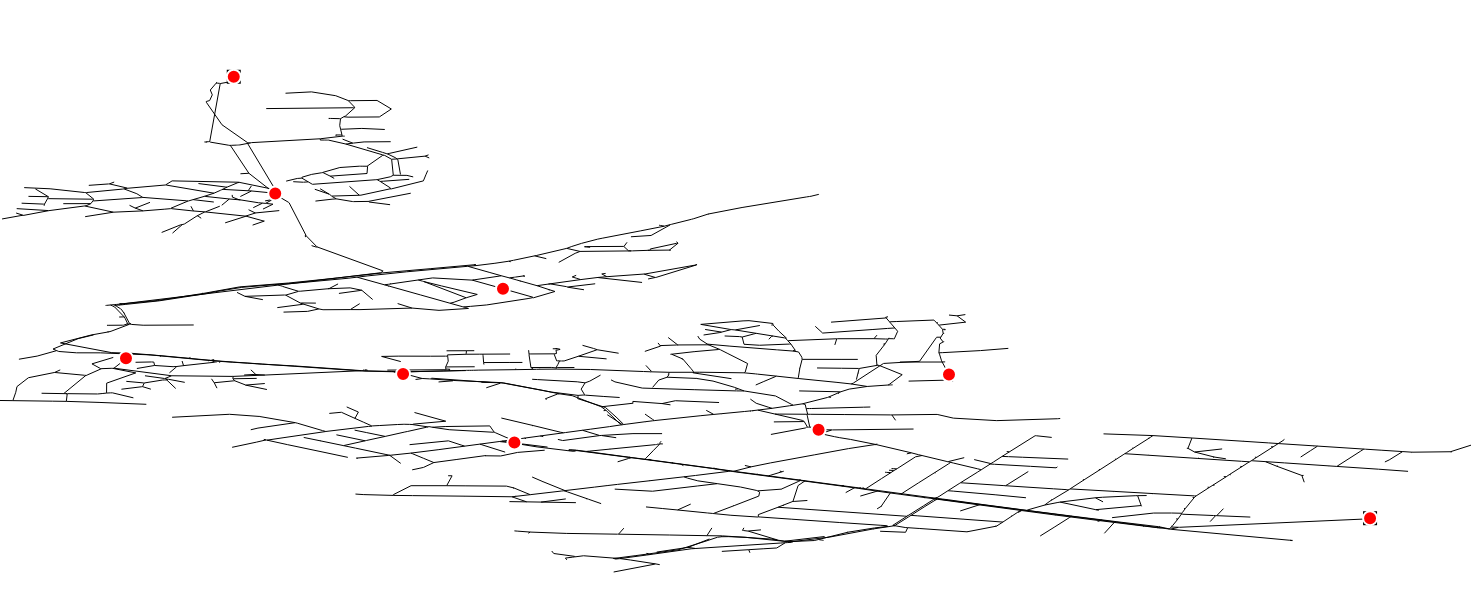

In [84]:
plot_network(link_df, reservoir=True, wq_sensors=True)